(ch_call_overhead)=
# 函数调用的开销

从本章开始对各种调度进行基准测试。在深入研究各种执行时间之前，需要知道在 Python 中发出函数调用的开销（overhead）。众所周知，Python 并不是地球上最快的语言。用 Python 创建原型很快，但也需要付出代价，因为 Python 在钩子下做了聪明的事情。在本节中，将研究在 Python 中调用函数的开销，并演示它对我们以后的基准测试结果的影响。

## 度量执行时间

在 Python 中，经常使用 `timeit` 模块对工作负载进行基准测试，特别是当它的执行时间远远小于 1 秒时。请注意，Jupyter 有个神奇的内置函数 `%timeit` 更简单，但使用它的函数不能被保存以供将来使用，所以我们将直接使用 `timeit`。

In [1]:
import timeit
import numpy as np
from matplotlib import pyplot as plt
from IPython import display

以下代码返回创建 `[4, 4]` 零矩阵 10 次的执行时间。

In [2]:
timer = timeit.Timer(setup='import numpy as np',
                     stmt='np.zeros((4, 4))')
timer.timeit(10)

1.2598989997059107e-05

可以看到，上述工作负载可以在几十微秒内完成，可能需要增加重复的数量，以获得相对准确的执行时间。下面的函数将确定运行工作负载至少 1 秒所需的重复次数，然后返回平均执行时间。

In [3]:
# 保存到 d2ltvm
def bench_workload(workload):
    """Benchmark a workload
    
    workload: a method that accept a num_repeat argument 
    and return its total execution time
    """
    workload(1)  # warmup
    time = workload(1)  # the time to run once
    if time > 1: return time
    # The number of repeats to measure at least 1 second
    num_repeats = max(int(1.0 / time), 5)
    return workload(num_repeats) / num_repeats

print(f'time for np.zeros((4, 4)): {bench_workload(timer.timeit)}')

time for np.zeros((4, 4)): 1.9588895971680033e-07


可以看到 `np.zeros((4, 4))` 的新测量的执行时间比第一次测量的零要小得多，因为第一次测量包括了热身（warmup）时间。

## 不小的开销

现在对 `copyto` 方法进行基准测试，它将 ndarray 的内容复制到另一个大小不同的 ndarray 中。

In [4]:
def np_setup(n):
    return ('import numpy as np\n'
    f'x = np.random.normal(size={n:d}).astype("float32")\n'
    'y = np.empty_like(x)\n')


def np_copy(n):
    return timeit.Timer(setup=np_setup(n),
                        stmt='np.copyto(y, x)')


sizes = 2**np.arange(5, 20, 4).astype('int')
exe_times = [bench_workload(np_copy(n).timeit) for n in sizes]

绘制吞吐量（throughput）与向量长度的关系图。

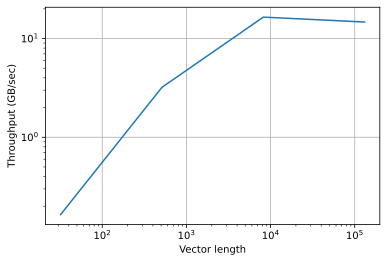

In [5]:
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')
# one float32 takes 4 bytes
plt.loglog(sizes, sizes*4/exe_times/1e9)
plt.xlabel('Vector length')
plt.ylabel('Throughput (GB/sec)')
plt.grid()

可以看到，吞吐量先是增加，然后趋于平稳。平台反映了内存带宽的饱和。然而，小向量的行为并不像预期的那样，因为当向量长度很小时，所有数据都应该在缓存中，这应该导致更高的吞吐量。为了分析原因，简单地画出执行时间与向量长度的关系。

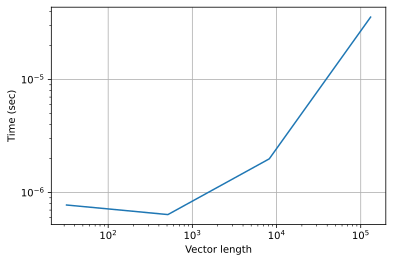

In [6]:
plt.loglog(sizes, exe_times)
plt.xlabel('Vector length')
plt.ylabel('Time (sec)')
plt.grid()

可以看到，当向量长度小于 $10^3$ 时，当向量长度缩短时，执行时间几乎没有减少。这是因为当向量长度很短时，真正的 `copyto` 执行时间太小，而总执行时间主要由函数调用开销决定。开销包括 Python 函数中的任何参数预处理，调用外部函数接口，以及其他 [Python 后端开销](https://jakevdp.github.io/blog/2014/05/09/why-python-is-slow/)。因此，基准测试过小的工作负载是没有意义的。

## NumPy、TVM 和 MXNet 的开销

在本书中，将对 Numpy、TVM 和 MXNet 中的各种算子进行基准测试。检查一下它们的函数调用开销。可以通过执行一些较小的工作负载来粗略估计它，这些工作负载的实际执行时间与开销相比可以忽略不计。首先检查 NumPy。

In [7]:
sizes = 2**np.arange(1, 20).astype('int')
exe_times = np.array([bench_workload(np_copy(n).timeit) for n in sizes])

print(f'NumPy call overhead: {exe_times.mean()*1e6: .7f} microsecond')

NumPy call overhead:  13.9122394 microsecond


TVM 的开销较高，但量级相同。

In [8]:
def tvm_copy(n):
    return timeit.Timer(setup=np_setup(n)+'import tvm\n'
                        'x, y = tvm.nd.array(x), tvm.nd.array(y)',
                        stmt='x.copyto(y)')

tvm_times = np.array([bench_workload(tvm_copy(n).timeit) for n in sizes])
print(f'TVM call overhead: {exe_times.mean()*1e6: .7f} microsecond')

TVM call overhead:  13.9122394 microsecond


与 NumPy 和 TVM 相比，MXNet 的开销要高得多。原因可能是 MXNet 使用 `ctypes`，而 TVM 是用 `cython` 编译的，而 MXNet 使用惰性计算带来额外的开销。

In [9]:
def mx_copy(n):
    return timeit.Timer(setup=np_setup(n)+'import mxnet as mx\n'
                        'x, y = mx.nd.array(x), mx.nd.array(y)\n'
                        'mx.nd.waitall()'% n,
                        stmt='x.copyto(y); y.wait_to_read()')

mx_times = np.array([bench_workload(mx_copy(n).timeit) for n in sizes])
print(f'MXNet call overhead: {exe_times.mean()*1e6: .7f} microsecond')

MXNet call overhead:  13.9122394 microsecond


## 小结

- 通过提前几次运行方法来预热方法是测量其执行时间的好做法。
- 函数调用开销可能需要几微秒。在 Python 中对太小的函数进行基准测试是没有意义的。